# Advection in Spherical coordinates
In this notebook, we will solve the advection equation in spherical coordinates using the finite volume method. The notebook serves as the first attempt at testing the implementation of advection and diffusion terms in `PyFVTool`, and might be removed in the future.

In [1]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)
target_dir = os.path.abspath(os.path.join(current_dir, "..", "src"))
sys.path.append(target_dir)
# # Use a raw string for the path
# sys.path.append(r'C:\projects\git\PyFVTool\src')

# # Print sys.path to verify the path is added
# print(sys.path)

c:\Users\aaeft\Documents\GitHub\PyFVTool\examples-notebooks


In [2]:
from pyfvtool.mesh import SphericalGrid3D
import numpy as np

# Create a spherical grid with a 10 km thickness
r_earth = 6371.0e3  # Earth radius in meters
atm_layer_thickness = 10.0e3  # 10 km thickness
m = SphericalGrid3D(10, 100, 100, atm_layer_thickness, 2 * np.pi, 2 * np.pi)
# shift the grid to the Earth surface

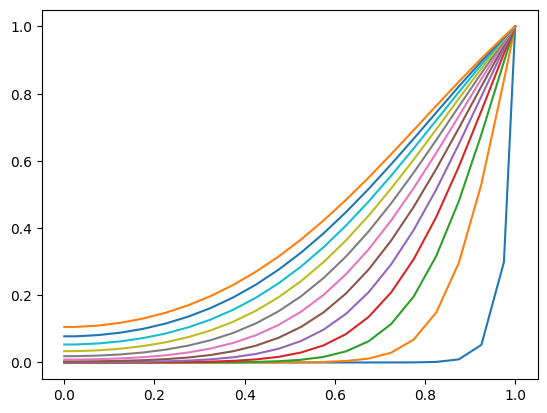

In [3]:
import pyfvtool as pf

# Solving a 1D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
Nx = 20  # number of finite volume cells
Lx = 1.0  # [m] length of the domain
c_left = 1.0  # left boundary concentration
c_init = 0.0  # initial concentration
D_val = 1e-5  # diffusion coefficient (gas phase)
t_simulation = 7200.0  # [s] simulation time
dt = 60.0  # [s] time step
Nskip = 10  # plot every Nskip-th profile

# Define mesh
mesh = pf.SphericalGrid1D(Nx, Lx)

# Create a cell variable with initial concentration
# By default, 'no flux' boundary conditions are applied
c = pf.CellVariable(mesh, c_init)

# Switch the right boundary to Dirichlet: fixed concentration
c.BCs.right.a[:] = 0.0
c.BCs.right.b[:] = 1.0
c.BCs.right.c[:] = c_left
c.apply_BCs()

# Assign diffusivity to cells
D_cell = pf.CellVariable(mesh, D_val)
D_face = pf.geometricMean(
    D_cell
)  # average value of diffusivity at the interfaces between cells

# Time loop
t = 0
nplot = 0
while t < t_simulation:
    # Compose discretized terms for matrix equation
    eqnterms = [pf.transientTerm(c, dt, 1.0), -pf.diffusionTerm(D_face)]

    # Solve PDE
    pf.solvePDE(c, eqnterms)
    t += dt

    if nplot % Nskip == 0:
        pf.visualizeCells(c)
    nplot += 1

60.0
120.0
180.0
240.0
300.0
360.0
420.0
480.0
540.0
600.0
660.0
720.0
780.0
840.0
900.0
960.0
1020.0
1080.0
1140.0
1200.0
1260.0
1320.0
1380.0
1440.0
1500.0
1560.0
1620.0
1680.0
1740.0
1800.0
1860.0
1920.0
1980.0
2040.0
2100.0
2160.0
2220.0
2280.0
2340.0
2400.0
2460.0
2520.0
2580.0
2640.0
2700.0
2760.0
2820.0
2880.0
2940.0
3000.0
3060.0
3120.0
3180.0
3240.0
3300.0
3360.0
3420.0
3480.0
3540.0
3600.0
3660.0
3720.0
3780.0
3840.0
3900.0
3960.0
4020.0
4080.0
4140.0
4200.0
4260.0
4320.0
4380.0
4440.0
4500.0
4560.0
4620.0
4680.0
4740.0
4800.0
4860.0
4920.0
4980.0
5040.0
5100.0
5160.0
5220.0
5280.0
5340.0
5400.0
5460.0
5520.0
5580.0
5640.0
5700.0
5760.0
5820.0
5880.0
5940.0
6000.0
6060.0
6120.0
6180.0
6240.0
6300.0
6360.0
6420.0
6480.0
6540.0
6600.0
6660.0
6720.0
6780.0
6840.0
6900.0
6960.0
7020.0
7080.0
7140.0
7200.0


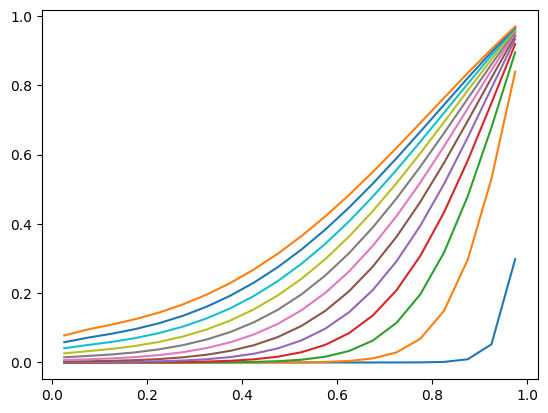

In [8]:
import pyfvtool as pf

# reload the module to get the updated version
import importlib

importlib.reload(pf)

import numpy as np
import matplotlib.pyplot as plt

# Solving a 3D diffusion equation with a fixed concentration
# at the left boundary and a closed boundary on the right side


# Calculation parameters
Nx = 20  # number of finite volume cells
Ntheta = 5  # number of cells in the theta direction
Nphi = 5  # number of cells in the phi direction
Lx = 1.0  # [m] length of the domain
c_left = 1.0  # left boundary concentration
c_init = 0.0  # initial concentration
D_val = 1e-5  # diffusion coefficient (gas phase)
t_simulation = 7200.0  # [s] simulation time
dt = 60.0  # [s] time step
Nskip = 10  # plot every Nskip-th profile

# Define mesh
mesh = pf.SphericalGrid3D(Nx, Ntheta, Nphi, Lx, 2 * np.pi, 2 * np.pi)

# Create a cell variable with initial concentration
# By default, 'no flux' boundary conditions are applied
c = pf.CellVariable(mesh, c_init)

# Switch the right boundary to Dirichlet: fixed concentration
c.BCs.right.a[:] = 0.0
c.BCs.right.b[:] = 1.0
c.BCs.right.c[:] = c_left
c.apply_BCs()

# Assign diffusivity to cells
D_cell = pf.CellVariable(mesh, D_val)
D_face = pf.geometricMean(
    D_cell
)  # average value of diffusivity at the interfaces between cells

# Time loop
t = 0
nplot = 0
while t < t_simulation:
    # Compose discretized terms for matrix equation
    eqnterms = [pf.transientTerm(c, dt, 1.0), -pf.diffusionTerm(D_face)]

    # Solve PDE
    pf.solvePDE(c, eqnterms)
    t += dt
    print(t)
    if nplot % Nskip == 0:
        plt.plot(c.domain.cellcenters.r, c.value[:, 0, 0])
    nplot += 1

In [5]:
c.domain.cellcenters.r.size
c.domain.cellsize._x

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [6]:
target_dir

'c:\\Users\\aaeft\\Documents\\GitHub\\PyFVTool\\src'

In [7]:
import sympy as sp

# define the variables rp and dr
rp, dr = sp.symbols("rp dr")
# define the expression
expr = 1 / 3 * ((rp + dr / 2) ** 3 - (rp - dr / 2) ** 3)
# expand the expression
expr = sp.expand(expr)
# print the expression
print(expr)
# print it in LaTeX format
print(sp.latex(expr))
# print it in mathematical format
print(sp.pretty(expr))
# print in a fancier mathematical format
sp.pprint(expr)
# calculate the expression for rp = 1 and dr = 0.1
expr.subs({rp: 2, dr: 0.1})
# compare with dr*rp**2
(expr.subs({rp: 2, dr: 0.1}) - 0.1 * 2**2) / expr.subs({rp: 2, dr: 0.1})

0.0833333333333333*dr**3 + 1.0*dr*rp**2
0.0833333333333333 dr^{3} + 1.0 dr rp^{2}
                     3            2
0.0833333333333333⋅dr  + 1.0⋅dr⋅rp 
                     3            2
0.0833333333333333⋅dr  + 1.0⋅dr⋅rp 


0.000208289939595895